# Модель предсказания оттока клиентов телекоммуникационной компании

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого сотрудники компании начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача заключается в обучении модели на этих данных для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов:
  - через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия»)
  - через оптоволоконный кабель (англ. fiber optic).
- Также абонентам доступен ряд услуг:
  - Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
  - Выделенная линия технической поддержки (Tech Support);
  - Облачное хранилище файлов для резервного копирования данных (Online Backup);
  - Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных**

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- **contract** — информация о договорах;
- **personal** — персональные данные клиентов;
- **internet** — информация об интернет-услугах;
- **phone** — информация об услугах телефонии.

**План по выполнению проекта**
1. Загрузка данных
2. Исследовательский и предобработка данных
4. Обучение моделей
5. Тестирование модели
6. Общий вывод

Информация о договорах актуальна на 1 февраля 2020.

## Импорт библиотек

In [1]:
!pip install -q phik
!pip install -q catboost
!pip install -q dask[dataframe]

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

#для работы с регулярными выражениями
import re

# Библиотеки визуализации
import seaborn as sns
from matplotlib import pyplot as plt

# sql
from sqlalchemy import create_engine, inspect

# Проверка на мультиколлинеарность
import phik
from phik.report import plot_correlation_matrix
from phik import report

#подготовка к созданию моделей

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

# Импорт моделей
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# кросс-валидация
from sklearn.model_selection import GridSearchCV

#создание нейронной сети:
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

# Импорт нужных инструментов для оценки метрики
from sklearn. metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,roc_auc_score, roc_curve, accuracy_score

In [3]:
# Константы
RANDOM_STATE = 16924

## Cоздание функций

In [4]:
# Информация о данных:
def info(data):
    '''
    1. Вывод информации о данных
    2. Вывод первых пяти строк данных с полным выводом всех столбцов
    3. Вывод сводной статистики
    4. Поиск и вывод количества дубликатов в данных
    '''
    data.info()
    pd.set_option('display.max_columns', None)
    display(data.head())
    # Сводная статистика данных
    display(data.describe())
    # Поиск дубликатов
    duplicates = data.duplicated().sum()
    print(f"Количество дубликатов в данных: {duplicates}")

In [5]:
#функция, которая принимает имя таблицы в качестве параметра и возвращает типы данных столбцов
def get_column_data_types(table_name, engine):
    data_types_query = f'''
                        PRAGMA table_info({table_name});
                        '''

    data_types = pd.read_sql_query(data_types_query, con=engine)
    return data_types[['name', 'type']]

In [6]:
def column_info(table_name, columns):

    column_info = []
    for column in columns:
        query = f'''
            SELECT
                '{column}' AS column_name,
                COUNT({column}) AS count_values,
                COUNT(DISTINCT {column}) AS count_unique_values,
                COUNT(*) - COUNT(DISTINCT {column}) AS count_duplicates,
                SUM(CASE WHEN {column} IS NULL THEN 1 ELSE 0 END) AS count_missing_values
            FROM {table_name};
        '''

        result = pd.read_sql_query(query, engine)
        column_info.append(result)

    return pd.concat(column_info, ignore_index=True)

In [7]:
def calculate_percentage_distribution(df, category_col, col):
    """
    Функция для подсчета распределения значений и преобразования их в проценты.
    Возвращает процентное распределение значений для каждой категории.
    """
    # Группируем данные по указанным категориям
    # затем считаем размер каждой группы и преобразуем в таблицу
    count_df = df.groupby([category_col, col]).size().unstack(fill_value=0)

    # Вычисляем процентное распределение для каждой категории
    percent_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

    return percent_df

In [8]:
def plot_column_distribution(df, column_name, xlabel, title):
    # Подсчет количества значений для указанного столбца и сортировка по убыванию
    column_counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)

    # Расчет процентного содержания
    total_count = len(df[column_name])
    percentages = [(count / total_count) * 100 for count in column_counts]

    # Создание столбчатой диаграммы с процентами
    plt.figure(figsize=(12, 5))
    bars = plt.bar(column_counts.index.astype(str), column_counts, color='skyblue')  # Преобразование индекса в строки

    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.title(title)
    plt.show()

In [9]:
# График распределения с квантилями
def plot_price(df, column):
    fig, ax = plt.subplots(figsize=(15, 5))

    df[column].value_counts().sort_index().plot(ax=ax)

    ax.set_xlabel(column)
    ax.set_ylabel('Количество')
    ax.set_title(f"Распределения столбца {column}")
    ax.grid(True)

    # Добавляем значения квантилей
    quantiles = df[column].quantile([0.25, 0.5, 0.75])
    for quantile in quantiles:
        ax.axvline(x=quantile, color='r', linestyle='--')
        ax.text(quantile, ax.get_ylim()[1]*0.95, f'Quantile {quantile}', rotation=90, va='top')

    plt.show()

## Загрузка данных

In [10]:
# подключение к базе данных в Sqlite
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2024-11-17 14:10:33--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.1’

ds-plus-final.db.1  100%[===================>]   3.42M  3.47MB/s    in 1.0s    

2024-11-17 14:10:34 (3.47 MB/s) - ‘ds-plus-final.db.1’ saved [3588096/3588096]



In [11]:
#Подключение к базе данных
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

## Исследование и предобработка данных

**Проверка соответствия количества таблиц и их названий**

In [12]:
# Создание инспектора
inspector = inspect(engine)

# Получение списка таблиц
tables = inspector.get_table_names()

# Вывод имен таблиц
for table in tables:
    print(table)

contract
data_arc
data_bulk
data_bulk_time
data_gas
data_temp
data_wire
data_wire_time
internet
personal
phone


Таблиц больше, чем в условие задачи.

In [13]:
data_query_1 = '''
                SELECT *
                FROM data_arc
                LIMIT 5;
                '''

data_query_2 = '''
                SELECT *
                FROM data_bulk
                LIMIT 5;
                '''

data_arc = pd.read_sql_query(data_query_1, con=engine)
data_bulk = pd.read_sql_query(data_query_2, con=engine)
display(data_arc)
display(data_bulk)



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,None,None,None,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,None,None,None,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


Дополнительные таблицы не относятся к данному проекту.

### Таблица contract

**Описание столбцов**
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

In [14]:
contract_data_types = get_column_data_types('contract', engine)
print(contract_data_types)

               name  type
0        customerID  TEXT
1         BeginDate  TEXT
2           EndDate  TEXT
3              Type  TEXT
4  PaperlessBilling  TEXT
5     PaymentMethod  TEXT
6    MonthlyCharges  TEXT
7      TotalCharges  TEXT


Названия окон соответствует исходным данным. Все столбцы имеют текстовый тип данных.

In [15]:
table_name = 'contract'
columns = ['customerID', 'BeginDate', 'EndDate', 'Type',	'PaperlessBilling',	'PaymentMethod',	'MonthlyCharges',	'TotalCharges']
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,customerID,7043,7043,0,0
1,BeginDate,7043,77,6966,0
2,EndDate,7043,67,6976,0
3,Type,7043,3,7040,0
4,PaperlessBilling,7043,2,7041,0
5,PaymentMethod,7043,4,7039,0
6,MonthlyCharges,7043,1585,5458,0
7,TotalCharges,7043,6658,385,0


Пропуски отсутствуют, количество строк 7043, все id уникальны.

In [16]:
#выгрузка таблицы contract
contract_query = '''
                            SELECT *
                            FROM contract;
                            '''
data_contract = pd.read_sql_query(contract_query, con=engine)

In [17]:
# переименование столбцов
data_contract.columns = [re.sub('(?<!^)(?=[A-Z])', '_', col).lower() for col in data_contract.columns]
data_contract.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)

In [18]:
info(data_contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        7043 non-null   object
 1   begin_date         7043 non-null   object
 2   end_date           7043 non-null   object
 3   type               7043 non-null   object
 4   paperless_billing  7043 non-null   object
 5   payment_method     7043 non-null   object
 6   monthly_charges    7043 non-null   object
 7   total_charges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,1585,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,20.05,
freq,1,366,5942,3875,4171,2365,61,11


Количество дубликатов в данных: 0


1. Необходимо переименовать столбцы в соответствии с рекомендациями PEP 8.
2.
   - Столбец BeginDate переведу в тип данных date.
   - Столбцы MonthlyCharges и TotalCharges переведу в тип данных float.
3. В столбце EndDate содержится либо дата окончания действия договора, либо 'No', что, вероятно, свидетельствует о том, что договор является действующим на момент выгрузки данных. Используя данные этого столбца, создам два новых признака: булевый признак - ушел клиент или нет, а также признак с длительностью контракта абонента.

### Таблица personal

**Описание столбцов**
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

In [19]:
personal_data_types = get_column_data_types('personal', engine)
print(personal_data_types)

            name  type
0     customerID  TEXT
1         gender  TEXT
2  SeniorCitizen  TEXT
3        Partner  TEXT
4     Dependents  TEXT


В таблице присутствуют все столбцы, описанные в исходных данных. Все признаки имеют строковый тип данных.

In [20]:
table_name = 'personal'
columns = ['customerID', 'gender', 'SeniorCitizen', 'Partner',	'Dependents']
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,customerID,7043,7043,0,0
1,gender,7043,2,7041,0
2,SeniorCitizen,7043,2,7041,0
3,Partner,7043,2,7041,0
4,Dependents,7043,2,7041,0


Все признаки имеют по два значения, всего 7043 строк, как и в таблице contract.

In [21]:
#выгрузка таблицы personal
personal_query = '''
                            SELECT *
                            FROM personal;
                            '''

data_personal = pd.read_sql_query(personal_query, con=engine)

In [22]:
# переименование столбцов
data_personal.columns = [re.sub('(?<!^)(?=[A-Z])', '_', col).lower() for col in data_personal.columns]
data_personal.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)

In [23]:
info(data_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7590-VHVEG,Male,0,No,No
freq,1,3555,5901,3641,4933


Количество дубликатов в данных: 0


### Таблица internet

**Описание столбцов**
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

In [24]:
internet_data_types = get_column_data_types('internet', engine)
print(internet_data_types)

               name  type
0        customerID  TEXT
1   InternetService  TEXT
2    OnlineSecurity  TEXT
3      OnlineBackup  TEXT
4  DeviceProtection  TEXT
5       TechSupport  TEXT
6       StreamingTV  TEXT
7   StreamingMovies  TEXT


В таблице присутствуют все столбцы, описанные в исходных данных. Все признаки имеют строковый тип данных.

In [25]:
table_name = 'internet'
columns = ['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',	'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,customerID,5517,5517,0,0
1,InternetService,5517,2,5515,0
2,OnlineSecurity,5517,2,5515,0
3,OnlineBackup,5517,2,5515,0
4,DeviceProtection,5517,2,5515,0
5,TechSupport,5517,2,5515,0
6,StreamingTV,5517,2,5515,0
7,StreamingMovies,5517,2,5515,0


Все признаки имеют по два значения, всего 5517 строк, меньше, чем в первых двух таблицах.

In [26]:
#выгрузка таблицы internet
internet_query = '''
                            SELECT *
                            FROM internet;
                            '''

data_internet = pd.read_sql_query(internet_query, con=engine)

In [27]:
# переименование столбцов
data_internet.columns = [re.sub('(?<!^)(?=[A-Z])', '_', col).lower() for col in data_internet.columns]
data_internet.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
data_internet.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)

In [28]:
info(data_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество дубликатов в данных: 0


## Таблица phone

**Описание столбцов**
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.


In [29]:
table_name = 'phone'
columns = ['customerID', 'MultipleLines']
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,customerID,6361,6361,0,0
1,MultipleLines,6361,2,6359,0


Все признаки имеют по два значения, всего 6361 строк, меньше, чем в первых двух таблицах. Количество столбцов соответствует исходным данным.

In [30]:
#выгрузка таблицы phone
phone_query = '''
                            SELECT *
                            FROM phone;
                            '''

data_phone = pd.read_sql_query(phone_query, con=engine)
data_phone.head()

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [31]:
# переименование столбцов
data_phone.columns = [re.sub('(?<!^)(?=[A-Z])', '_', col).lower() for col in data_phone.columns]
data_phone.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)

In [32]:
info(data_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Количество дубликатов в данных: 0


### Объединение таблиц

Объединение таблиц будет выполнено по ID клиента.

Для объединения таблиц, содержащих информацию о договорах и персональных данных, используется метод merge с параметром inner. Это позволяет создать результирующий DataFrame, включающий только те строки, которые имеют совпадающие значения в столбце customer_id во всех таблицах. В случае таблиц, содержащих данные об услугах интернета и телефонии, я буду использовать полный метод объединения, так как могут быть клиенты, пользующиеся только одним видом услуги.

In [33]:
# Объединение таблиц по customer_id
data = (
    data_contract
    .merge(data_personal, on='customer_id', how='inner')
    .merge(data_internet, on='customer_id', how='outer')
    .merge(data_phone, on='customer_id', how='outer')
)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        7043 non-null   object
 1   begin_date         7043 non-null   object
 2   end_date           7043 non-null   object
 3   type               7043 non-null   object
 4   paperless_billing  7043 non-null   object
 5   payment_method     7043 non-null   object
 6   monthly_charges    7043 non-null   object
 7   total_charges      7043 non-null   object
 8   gender             7043 non-null   object
 9   senior_citizen     7043 non-null   object
 10  partner            7043 non-null   object
 11  dependents         7043 non-null   object
 12  internet_service   5517 non-null   object
 13  online_security    5517 non-null   object
 14  online_backup      5517 non-null   object
 15  device_protection  5517 non-null   object
 16  tech_support       5517 non-null   object


In [35]:
# Рассчитываем процент пропусков в каждом столбце
data.isnull().mean().round(2) * 100

,0
customer_id,0.0
begin_date,0.0
end_date,0.0
type,0.0
paperless_billing,0.0
payment_method,0.0
monthly_charges,0.0
total_charges,0.0
gender,0.0
senior_citizen,0.0


In [36]:
#заполнение пропусков
phone_missing_columns = ['multiple_lines']
internet_missing_columns = ['internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv','streaming_movies']

data[internet_missing_columns] = data[internet_missing_columns].fillna('NO_INTERNET')
data[phone_missing_columns] = data[phone_missing_columns].fillna('NO_PHONE')

In [37]:
#Изменение типа данных

# Преобразование столбца из str в datetime
data['begin_date'] = pd.to_datetime(data['begin_date'])

# Преобразование столбца из str в float
data['monthly_charges'] = data['monthly_charges'].astype(float)
data['total_charges'] = data['total_charges'].str.strip().replace('', np.nan).astype(float)

In [38]:
# Создание признака 'departed': если клиент ушел, то 1, не ушел 0
data['departed']=np.where(((data['end_date'].isin(['No']))),0,1).astype(bool)

In [39]:
data['departed'].value_counts(normalize=True)

,proportion
departed,
False,0.843675
True,0.156325


В данных клиентов, которые ушли из компании 15.6% - это явный дисбаланс классов.

### Анализ категориальных данных

#### Информация о договорах

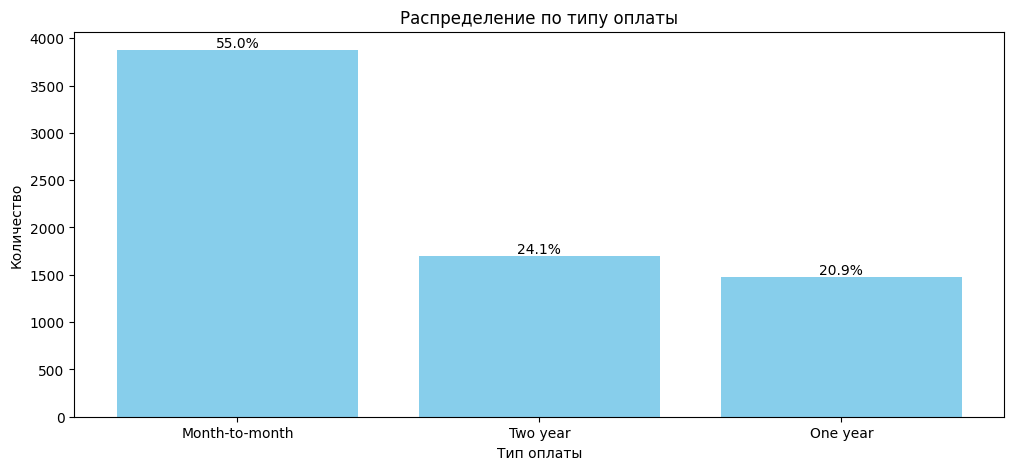

In [40]:
plot_column_distribution(data, 'type', 'Тип оплаты', 'Распределение по типу оплаты')

In [41]:
# Подсчет распределения и преобразование в проценты
calculate_percentage_distribution(data, 'type', 'departed')

departed,False,True
type,,
Month-to-month,89.496774,10.503226
One year,78.750849,21.249151
Two year,77.522124,22.477876


Способ оплаты соответствует описанию данных и делится на три категории: ежегодно, раз в два года или ежемесячно.

Среди тех, кто платил ежемесячно, только 11% расторгли договор. Среди тех, кто оплачивает раз в год, раз в два года, процент расторжений вдвое выше (21% и 22% соответственно).

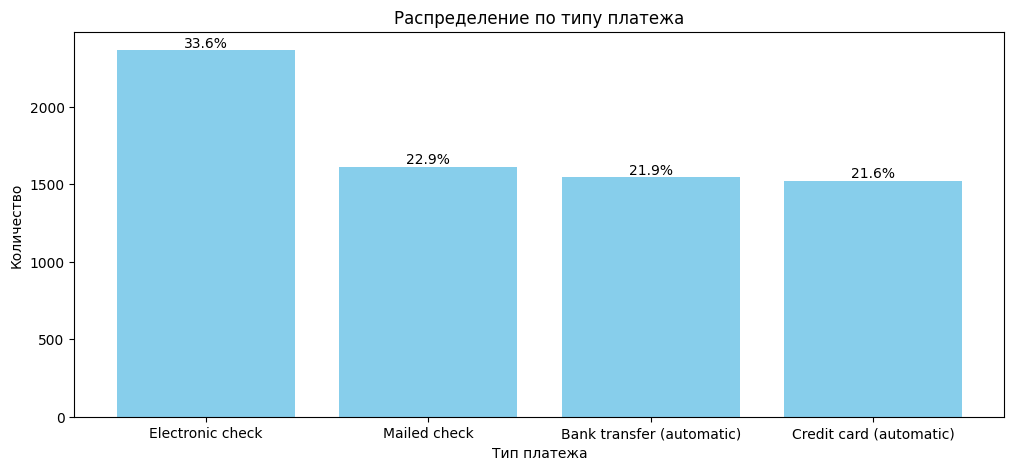

In [42]:
plot_column_distribution(data, 'payment_method', 'Тип платежа', 'Распределение по типу платежа')

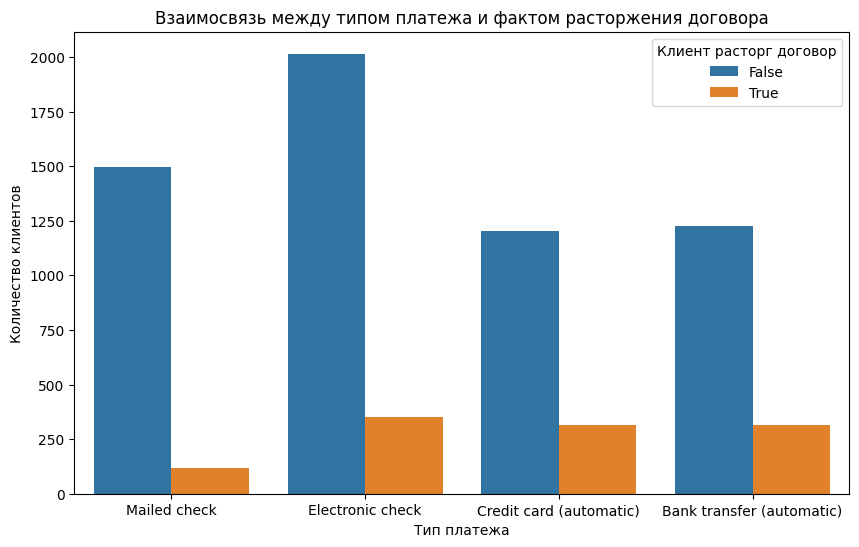

In [43]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.countplot(x='payment_method', hue='departed', data=data)
plt.title('Взаимосвязь между типом платежа и фактом расторжения договора')
plt.xlabel('Тип платежа')
plt.ylabel('Количество клиентов')
plt.legend(title='Клиент расторг договор')
plt.show()

In [44]:
# Подсчет распределения и преобразование в проценты
calculate_percentage_distribution(data, 'payment_method', 'departed')

departed,False,True
payment_method,,
Bank transfer (automatic),79.468912,20.531088
Credit card (automatic),79.172142,20.827858
Electronic check,85.200846,14.799154
Mailed check,92.741935,7.258065


Наиболее популярным среди пользователей является электронный чек (33,6%). Остальные типы платежей используются примерно одинаково, по 20% клиентов для каждого из них. Из клиентов, использующих банковский перевод и кредитную карту, 20% отказались от услуг оператора связи. Среди клиентов, использующих электронный чек, отказ составил 15%, а среди тех, кто использовал чек, отправленный по почте — 7%.

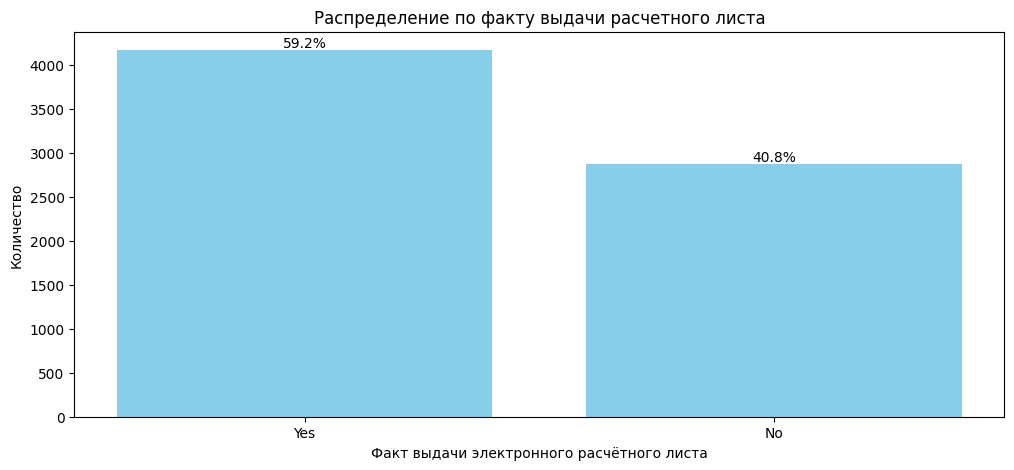

In [45]:
plot_column_distribution(data, 'paperless_billing', 'Факт выдачи электронного расчётного листа', 'Распределение по факту выдачи расчетного листа')

In [46]:
# Подсчет распределения и преобразование в проценты
calculate_percentage_distribution(data, 'paperless_billing', 'departed')

departed,False,True
paperless_billing,,
No,86.768802,13.231198
Yes,82.713977,17.286023


Как я понимаю, данный признак обозначает, получает ли клиент счета в электронном виде (true) или в бумажном (false). Больше половины клиентов запрашивали электронный расчетный лист (59.2%)

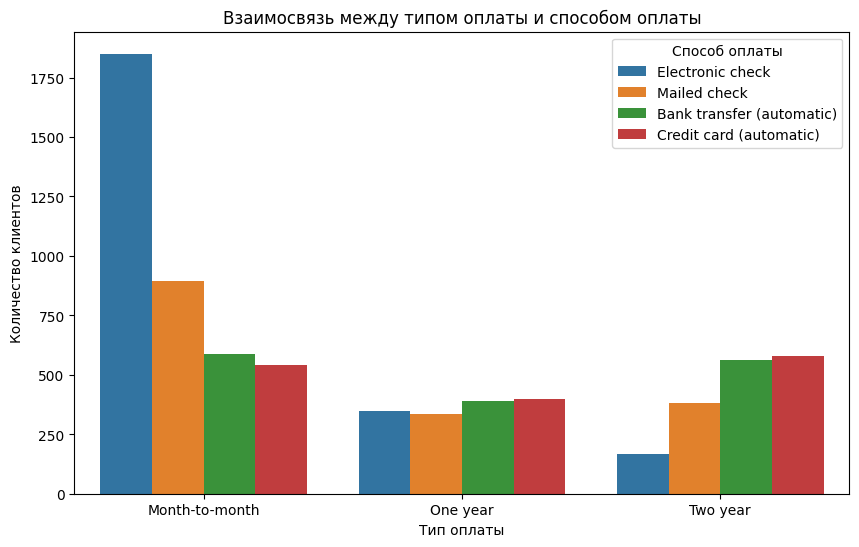

In [47]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='payment_method', data=data_contract)
plt.title('Взаимосвязь между типом оплаты и способом оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество клиентов')
plt.legend(title='Способ оплаты')
plt.show()

Для клиентов, которые оплачивают услуги оператора раз в год и раз в два года, предпочтительным способом оплаты является автоматический перевод. В то же время, для клиентов, предпочитающих помесячную оплату, основным способом оплаты является электронный чек.

Клиенты, выбирающие долгосрочные планы, чаще используют автоматические переводы, что может указывать на их стремление к удобству и автоматизации платежей. В то время как клиенты, предпочитающие помесячные платежи, ориентированы на более гибкие и контролируемые способы оплаты, такие как электронные чеки.

#### Персональные данные

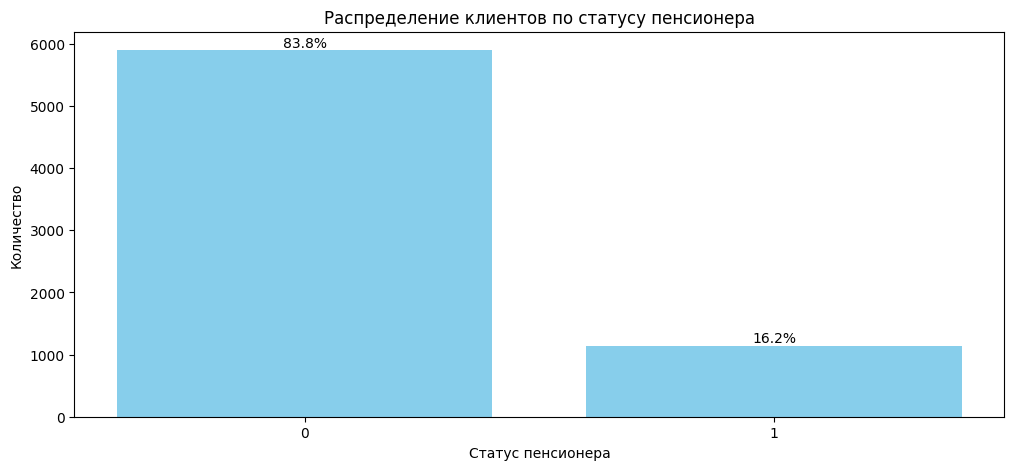

In [48]:
plot_column_distribution(data, 'senior_citizen', 'Статус пенсионера', 'Распределение клиентов по статусу пенсионера')

In [49]:
# Подсчет распределения и преобразование в проценты
calculate_percentage_distribution(data, 'senior_citizen', 'departed')

departed,False,True
senior_citizen,,
0,85.273682,14.726318
1,79.684764,20.315236


Пенсионерами являются 16% всех пользователей. Среди них процент расторгнутых договоров немного выше и составляет 20%, тогда как среди не пенсионеров этот показатель равен 15%.

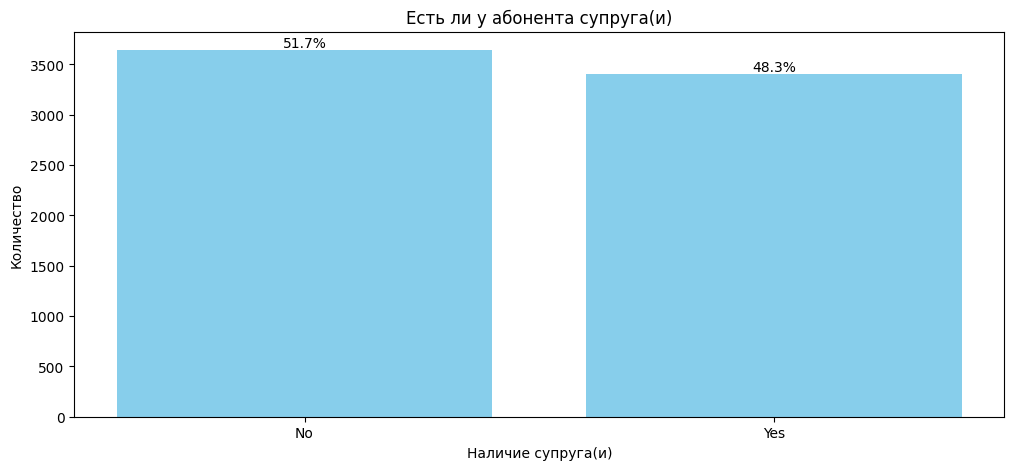

In [50]:
plot_column_distribution(data, 'partner', 'Наличие супруга(и)', 'Есть ли у абонента супруга(и)')

In [51]:
# Подсчет распределения и преобразование в проценты
calculate_percentage_distribution(data, 'partner', 'departed')

departed,False,True
partner,,
No,89.508377,10.491623
Yes,78.865373,21.134627


Клиенты, находящиеся в браке, составляют 48,3% всех пользователей. Среди них процент расторгнутых договоров в два раза выше и равен 21,1%, в то время как среди тех, кто не состоит в браке, этот показатель составляет 10,5%.

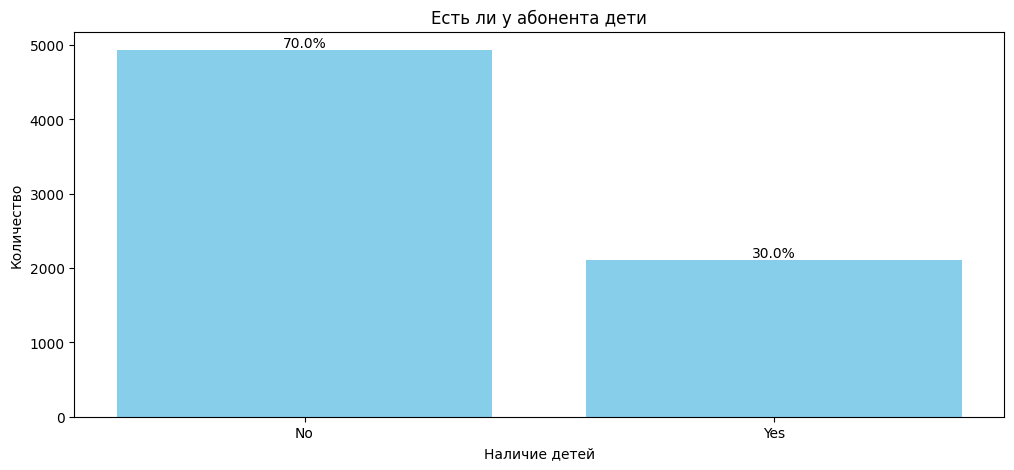

In [52]:
plot_column_distribution(data, 'dependents', 'Наличие детей', 'Есть ли у абонента дети')

In [53]:
# Подсчет распределения и преобразование в проценты
calculate_percentage_distribution(data, 'dependents', 'departed')

departed,False,True
dependents,,
No,85.140888,14.859112
Yes,82.559242,17.440758


Клиенты с детьми составляют 30% всех пользователей. Среди них процент расторгнутых договоров немного выше и равен 17,4%, в то время как среди тех, у кого нет детей, этот показатель составляет 14,9%.

#### Информация об интернет-услугах

In [54]:
# Создание таблицы распределения для указанных столбцов, исключая NO_INTERNET
distribution_tables = {column: (data.loc[data[column] != 'NO_INTERNET', column].value_counts(normalize=True).round(2) * 100) for
                       column in ['internet_service',
                                   'online_security',
                                   'online_backup',
                                   'device_protection',
                                   'tech_support',
                                   'streaming_tv'
                                   ] if column in data_internet.columns}

# Вывод таблиц распределения
for column, table in distribution_tables.items():
    print(f"Распределение для столбца {column}:\n{table}\n")

Распределение для столбца internet_service:
internet_service
Fiber optic    56.0
DSL            44.0
Name: proportion, dtype: float64

Распределение для столбца online_security:
online_security
No     63.0
Yes    37.0
Name: proportion, dtype: float64

Распределение для столбца online_backup:
online_backup
No     56.0
Yes    44.0
Name: proportion, dtype: float64

Распределение для столбца device_protection:
device_protection
No     56.0
Yes    44.0
Name: proportion, dtype: float64

Распределение для столбца tech_support:
tech_support
No     63.0
Yes    37.0
Name: proportion, dtype: float64

Распределение для столбца streaming_tv:
streaming_tv
No     51.0
Yes    49.0
Name: proportion, dtype: float64



In [55]:
# Создание таблицы распределения для признака 'departed' по указанным столбцам, исключая NO_INTERNET
distribution_tables = {}

for column in ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv']:
    if column in data.columns:
        distribution_tables[column] = data[data[column] != 'NO_INTERNET'].groupby(column)['departed'].value_counts(normalize=True).unstack().round(2)

# Вывод таблиц распределения
for column, table in distribution_tables.items():
    print(f"Распределение целевого признака 'departed' для столбца {column}:\n{table}\n")

Распределение целевого признака 'departed' для столбца internet_service:
departed          False  True 
internet_service              
DSL                0.86   0.14
Fiber optic        0.81   0.19

Распределение целевого признака 'departed' для столбца online_security:
departed         False  True 
online_security              
No                0.85   0.15
Yes               0.79   0.21

Распределение целевого признака 'departed' для столбца online_backup:
departed       False  True 
online_backup              
No              0.88   0.12
Yes             0.77   0.23

Распределение целевого признака 'departed' для столбца device_protection:
departed           False  True 
device_protection              
No                  0.87   0.13
Yes                 0.77   0.23

Распределение целевого признака 'departed' для столбца tech_support:
departed      False  True 
tech_support              
No             0.84   0.16
Yes            0.81   0.19

Распределение целевого признака 'departed' дл

1. Волоконно-оптическое подключение имеется у 56,1% пользователей, подключивших интернет у оператора связи. Среди них процент расторгнутых договоров немного выше и составляет 19,2%, тогда как у пользователей DSL-подключения этот показатель равен 14,3%.

2. Услугу блокировки опасных сайтов подключили 36,6% пользователей, имеющих интернет у оператора. Однако процент расторжений среди них составляет 20,5%, что на 5,5% выше, чем у тех, кто не использует данную услугу.

3. Услуга облачного хранения данных доступна 44% пользователей, подключивших интернет у оператора, и среди них процент расторгнутых контрактов составляет 23%. Это на 10% выше, чем у тех, кто не использует облачные решения.

4. Аналогичная ситуация наблюдается и среди клиентов, использующих антивирусное ПО: 44% пользователей, имеющих интернет у оператора, но уровень расторжений также на уровне 23%.

5. Услуга выделенной линии технической поддержки охватывает 37% пользователей, подключивших интернет. Процент расторжений в этой группе составляет 19,5%, что на 4% выше, чем у тех, кто не подключал эту услугу.

6. Услуга стримингового телевидения интересует 49% пользователей, имеющих интернет у оператора, и среди них процент расторжений на уровне 21,5%. Это на 9% выше, чем у тех, кто не подключал данную услугу.

7. Наконец, пользователи, подключившие каталог фильмов, составляют 49,5% тех, кто пользуется интернетом у оператора связи. Процент расторжений в этой группе достигает 22%, что на 10% выше, чем у тех, кто не использует эту услугу.


#### Информация об услугах телефонии

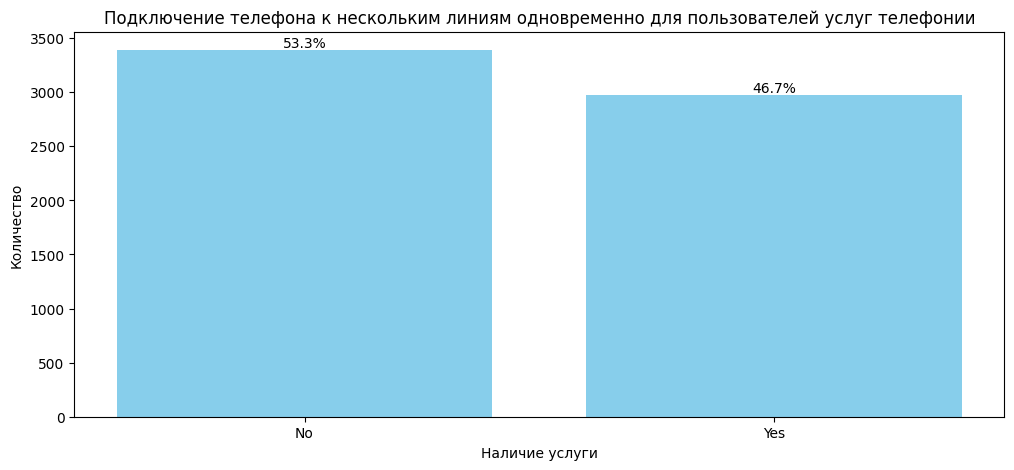

In [56]:
plot_column_distribution(data.query('multiple_lines != "NO_PHONE"'), 'multiple_lines', 'Наличие услуги', 'Подключение телефона к нескольким линиям одновременно для пользователей услуг телефонии')

In [57]:
# Подсчет распределения и преобразование в проценты
calculate_percentage_distribution(data.query('multiple_lines != "NO_PHONE"'), 'multiple_lines', 'departed')

departed,False,True
multiple_lines,,
No,90.560472,9.439528
Yes,77.179401,22.820599


Клиенты, подключившие телефон к нескольким линиям одновременно, составляют 46,7% от общего числа пользователей услуг телефонии. Из них 22,8% расторгают контракт, что на 13,4% выше, чем у пользователей, не использующих эту услугу.

Пользователи, подключившие телефон к нескольким линиям, демонстрируют значительно более высокий уровень расторжения контрактов по сравнению с теми, кто не использует данное предложение. Это может свидетельствовать о существующих проблемах с удовлетворенностью или целесообразностью услуги.

### Анализ признаков с временными метками

In [58]:
# Удаление значений 'No' из data_contract['end_date']
data.loc[data['end_date']== 'No','end_date']= np.NAN

# Преобразование столбца из str в datetime
data['end_date'] = pd.to_datetime(data['end_date'])

In [59]:
# Проверка дат
display(data.query('begin_date >= end_date'))

print('Самая поздняя дата начала действия договора', data['begin_date'].max())
print('Самая раняя дата начала действия договора',data['begin_date'].min())
print('Самая поздняя дата окончания действия договора', data['end_date'].max())
print('Самая раняя дата окончания действия договора', data['end_date'].min())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,departed


Самая поздняя дата начала действия договора 2020-02-01 00:00:00
Самая раняя дата начала действия договора 2013-10-01 00:00:00
Самая поздняя дата окончания действия договора 2020-01-01 00:00:00
Самая раняя дата окончания действия договора 2014-06-01 00:00:00


В исходных данных указано, что информация о договорах актуальна на 1 февраля 2020 года. Более поздние даты отсутствуют.

Я заполню пропуски в данных об окончании действия договора на 2020-02-01 для создания признака с продолжительностью действия договора.

Перед этим проведу анализ распределения количества подключений за время, чтобы выявить сезонные закономерности по месяцам и влияние дня недели на желание заключить или расторгнуть договор.

In [60]:
# Копирование столбцов в отдельный датафрейм, чтобы не создавать новые столбцы в основном
data_time = data[['begin_date','end_date']].copy()

In [61]:
# Создание столбцов с днями недели
data_time['begin_date_day_of_week'] = data_time['begin_date']. dt.day_name ()
data_time['end_date_day_of_week'] = data_time['end_date']. dt.day_name ()

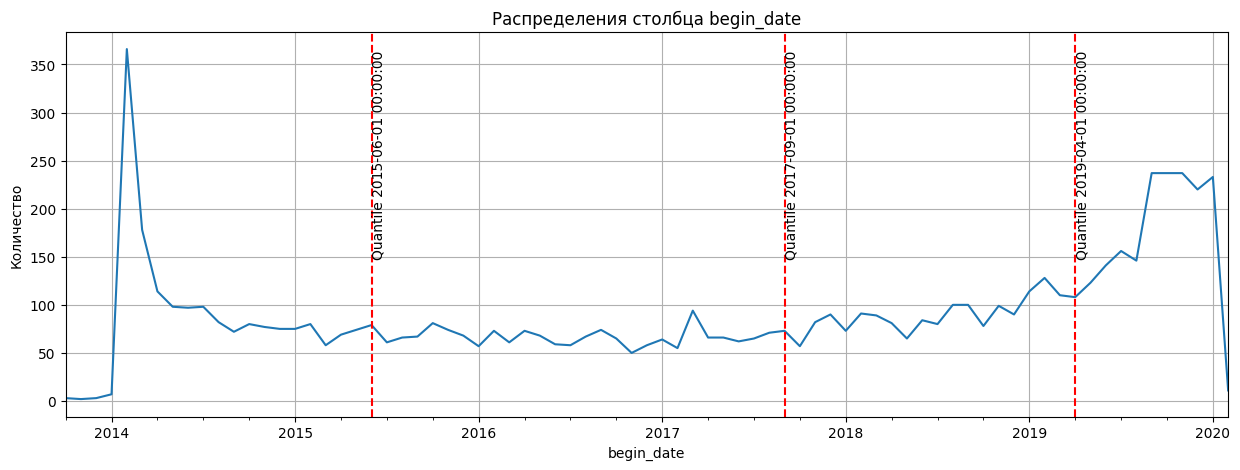

In [62]:
plot_price(data_time, 'begin_date')

В начале 2014 года наблюдался высокий всплеск подключений к оператору связи. С середины 2014 года до 2019 года количество подключений оставалось стабильным. В 2019 году количество подключений начало расти.

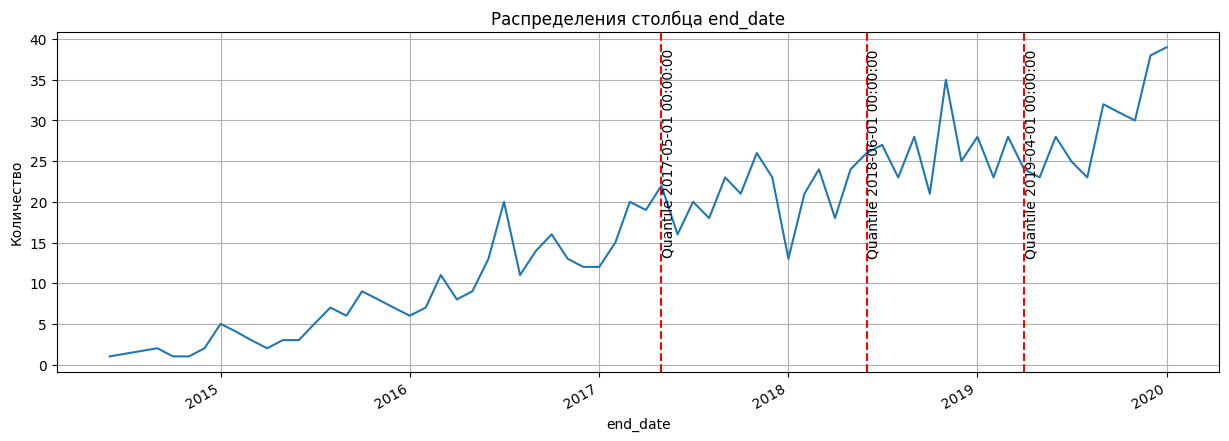

In [63]:
plot_price(data, 'end_date')

С июня 2014 года наблюдается тренд на увеличение количества расторгнутых договоров с оператором связи.

Графики распределения заключения и расторжения договоров не показывают сезонных колебаний. Закономерности, связанные с сезонами и месяцами, не наблюдаются.

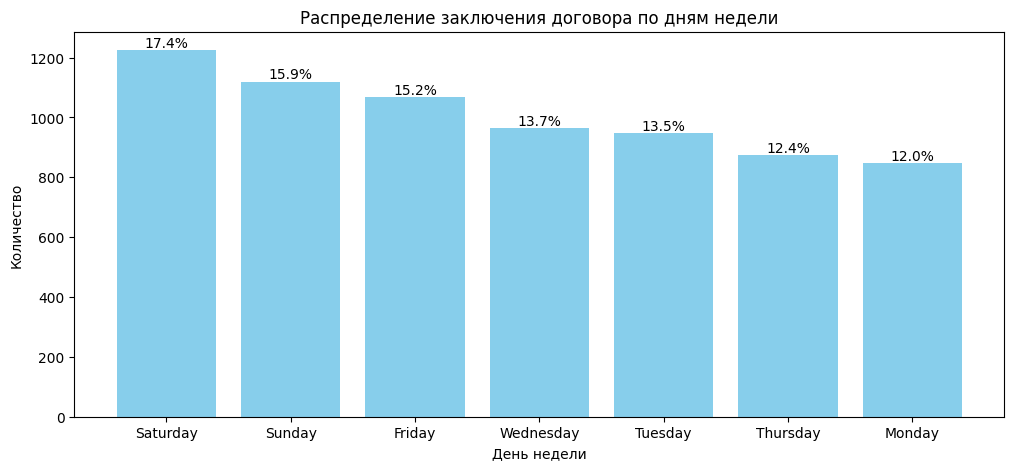

In [64]:
plot_column_distribution(data_time, 'begin_date_day_of_week', 'День недели', 'Распределение заключения договора по дням недели')

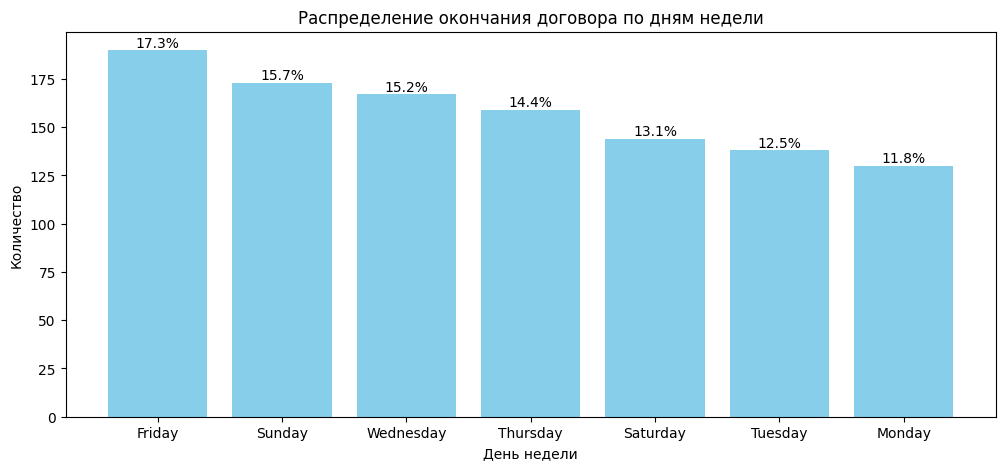

In [65]:
plot_column_distribution(data_time.loc[~data_time['end_date'].isna()], 'end_date_day_of_week', 'День недели',  'Распределение окончания договора по дням недели')

Чаще всего договора заключаются и расторгаются в пятницу, в выходные и в среду, в то время как наименьшая активность наблюдается в понедельник.

In [66]:
# Распределение значений продолжительности контракта для тех, кто расторгнул договор
data_time.dropna(axis=0, inplace=True)

# Заполнение нового столбца: длительность контракта абонента
data_time['contract_duration_for_departing'] = data_time['end_date'] - data_time['begin_date']

# Перевод в тип данных float (в годах) c округлением до 0.5
data_time['contract_duration_for_departing'] = (data_time['contract_duration_for_departing'].dt.days / 365).round(1).apply(lambda x: round(x * 2) / 2)

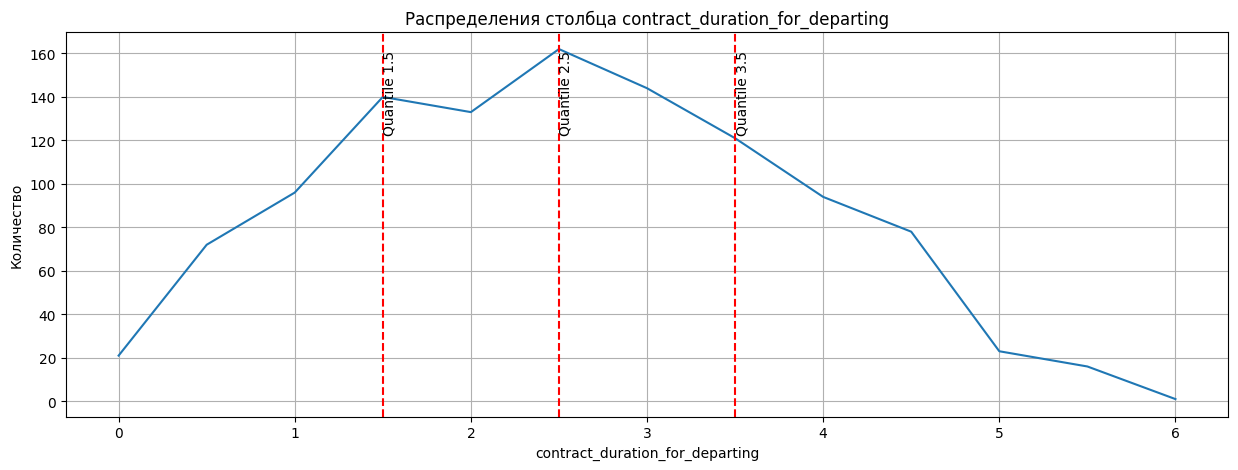

In [67]:
plot_price(data_time, 'contract_duration_for_departing')

В среднем, пользователи, принявшие решение о расторжении договора, использовали услуги оператора связи от 1.5 до 3.5 лет, при этом медианное значение составляет 2.5 года.

In [68]:
# Заполнение пропущенных значений конечной датой
data['end_date'].fillna(pd.Timestamp('2020-02-01'), inplace=True)

# Заполнение нового столбца: длительность контракта абонента
data['duration_of_contract'] = data['end_date'] - data['begin_date']

# Перевод в тип данных float (в днях)
data['duration_of_contract'] = data['duration_of_contract'].dt.days

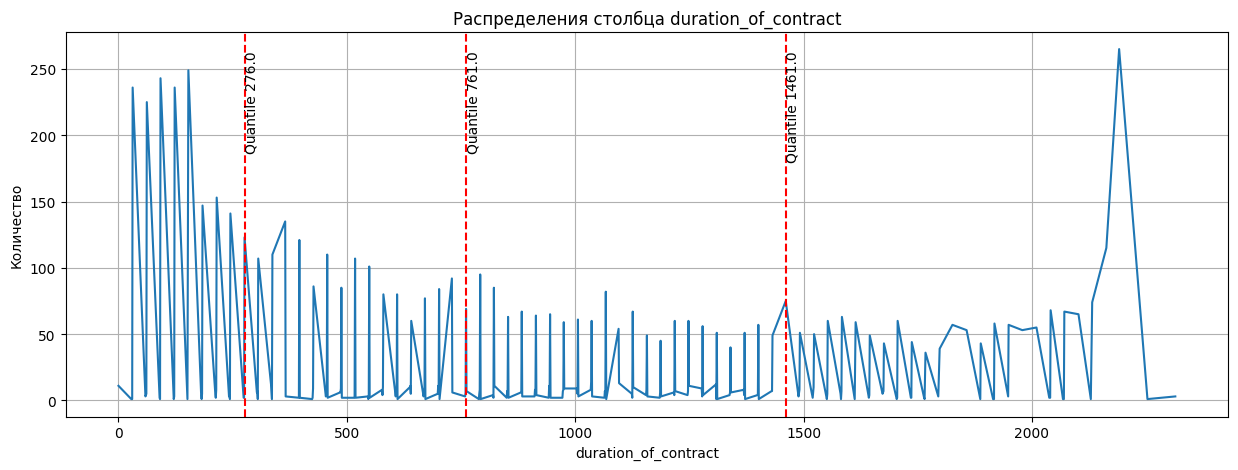

In [69]:
plot_price(data, 'duration_of_contract')

In [70]:
# Определение категорий
bins = [0, 365, 1460, float('inf')]
labels = ['до года', 'от года до четырех', 'больше 4 лет']

# Расчет статистики с использованием pd.cut напрямую в groupby
result = data.groupby(pd.cut(data['duration_of_contract'], bins=bins, labels=labels))['duration_of_contract'].agg(
    count='count',
    median='median',
    mean='mean'
).reset_index()

# Вычисление процентного соотношения
result['percentage'] = round((result['count'] / result['count'].sum()), 2) * 100

result

,duration_of_contract,count,median,mean,percentage
0,до года,2199,153.0,172.815371,31.0
1,от года до четырех,3067,822.0,857.178676,44.0
2,больше 4 лет,1766,1918.0,1879.694224,25.0


Анализ клиентов, как тех, кто расторг договор, так и тех, кто продолжает пользоваться услугами оператора связи, показывает, что большинство клиентов используют договор менее года (31%). С каждым последующим годом количество пользователей уменьшается. При этом основная группа клиентов состоит из тех, кто пользуется услугами от одного до четырех лет (44%), 25% клиентов остаются с оператором более четырех лет.

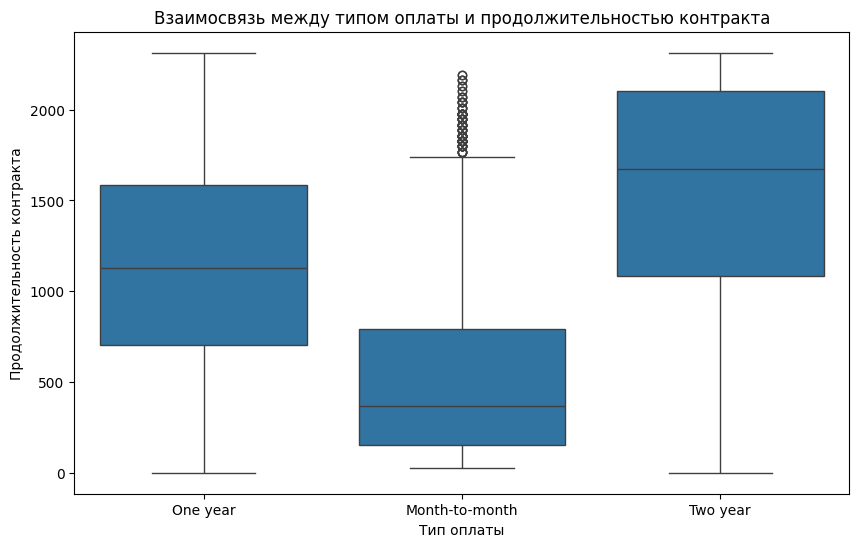

In [71]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='duration_of_contract', data=data)
plt.title('Взаимосвязь между типом оплаты и продолжительностью контракта')
plt.xlabel('Тип оплаты')
plt.ylabel('Продолжительность контракта')
plt.show()

 По графику видно, что клиенты, предпочитающие помесячную оплату, имеют медианную продолжительность контракта около года. Клиенты, оплачивающие раз в год, имеют медианную продолжительность пользования услугами оператора примерно 3.5 года. Тех, кто выбирает оплату раз в два года, медианное значение продолжительности составляет больше 4 лет.

Клиенты, выбирающие более длительные сроки оплаты, как правило, остаются с оператором дольше.

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   begin_date            7043 non-null   datetime64[ns]
 2   end_date              7043 non-null   datetime64[ns]
 3   type                  7043 non-null   object        
 4   paperless_billing     7043 non-null   object        
 5   payment_method        7043 non-null   object        
 6   monthly_charges       7043 non-null   float64       
 7   total_charges         7032 non-null   float64       
 8   gender                7043 non-null   object        
 9   senior_citizen        7043 non-null   object        
 10  partner               7043 non-null   object        
 11  dependents            7043 non-null   object        
 12  internet_service      7043 non-null   object        
 13  online_security   

### Анализ численных признаков

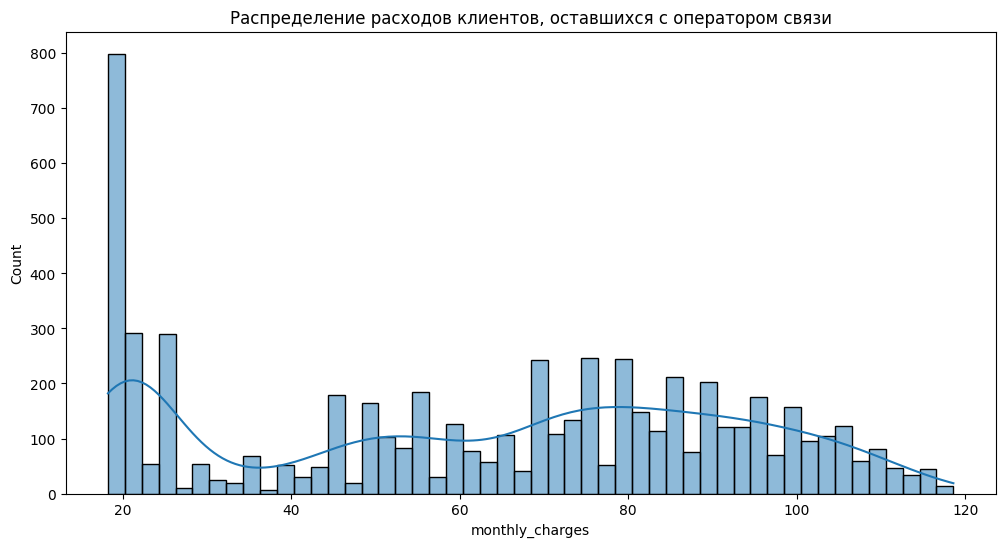

In [73]:
# Гистаграмма распределения расходов клиентов за месяц
plt.figure(figsize=(12, 6))
sns.histplot(data=data.query('departed == 0'), x='monthly_charges', bins=50, kde=True)
plt.title('Распределение расходов клиентов, оставшихся с оператором связи')
plt.show()

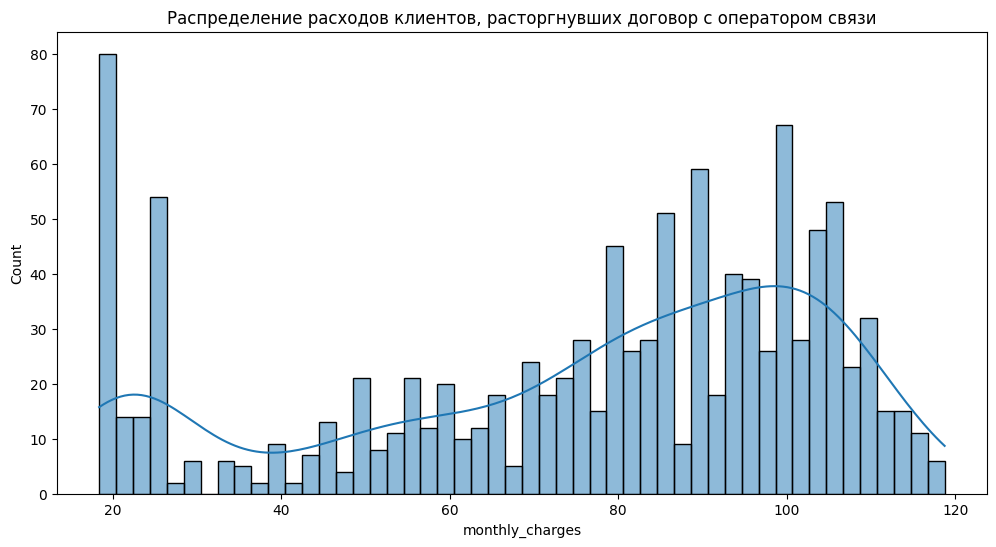

In [74]:
# Гистаграмма распределения расходов клиентов за месяц
plt.figure(figsize=(12, 6))
sns.histplot(data=data.query('departed == 1'), x='monthly_charges', bins=50, kde=True)
plt.title('Распределение расходов клиентов, расторгнувших договор с оператором связи')
plt.show()

In [75]:
# Создание таблицы квантилей
quantiles = data['monthly_charges'].quantile([0.25, 0.5, 0.75]).reset_index()
quantiles.columns = ['quantile', 'value']
quantiles

,quantile,value
0,0.25,35.50
1,0.50,70.35
2,0.75,89.85


In [76]:
# Определение категорий
bins = [0, 40, 90, float('inf')]
labels = ['до 40', 'от 40 до 90', 'выше 90']

# Расчет статистики с использованием pd.cut напрямую в groupby
result = data.groupby(pd.cut(data['monthly_charges'], bins=bins, labels=labels))['monthly_charges'].agg(
    count='count',
    median='median',
    mean='mean'
).reset_index()

# Вычисление процентного соотношения
result['percentage'] = round((result['count'] / result['count'].sum()), 2) * 100

result

,monthly_charges,count,median,mean,percentage
0,до 40,1838,20.35,22.875326,26.0
1,от 40 до 90,3466,70.70,68.782530,49.0
2,выше 90,1739,100.25,101.018689,25.0


In [77]:
# Вычисление отношения количества True и False для каждой группы с округлением до целого числа
ratio = data.groupby(
    pd.cut(data['monthly_charges'], bins=bins, labels=labels)
)['departed'].value_counts(normalize=True).unstack(fill_value=0).round(2)
ratio

departed,False,True
monthly_charges,,
до 40,0.90,0.10
от 40 до 90,0.86,0.14
выше 90,0.75,0.25


Основная группа клиентов ежемесячно выплачивает в среднем от 40 до 90 долларов, в среднем — 70. Эти клиенты составляют 49% от общего числа пользователей, из которых 14% отказались от услуг связи.

Клиентов также можно разделить на категории: те, кто тратит до 40 долларов (в среднем — 20), и те, кто тратит выше 90 долларов (в среднем — 100). Они составляют 26% и 25% пользователей соответственно.

Среди клиентов, тратящих до 40 долларов, 10% отказались от услуг оператора. Среди клиентов, тратящих от 40 до 90 долларов, 14% отказались от услуг. В то же время, среди клиентов, расходующих более 90 долларов в месяц, 25% отказались от услуг оператора, что делает эту группу самой значительной среди отказавшихся.

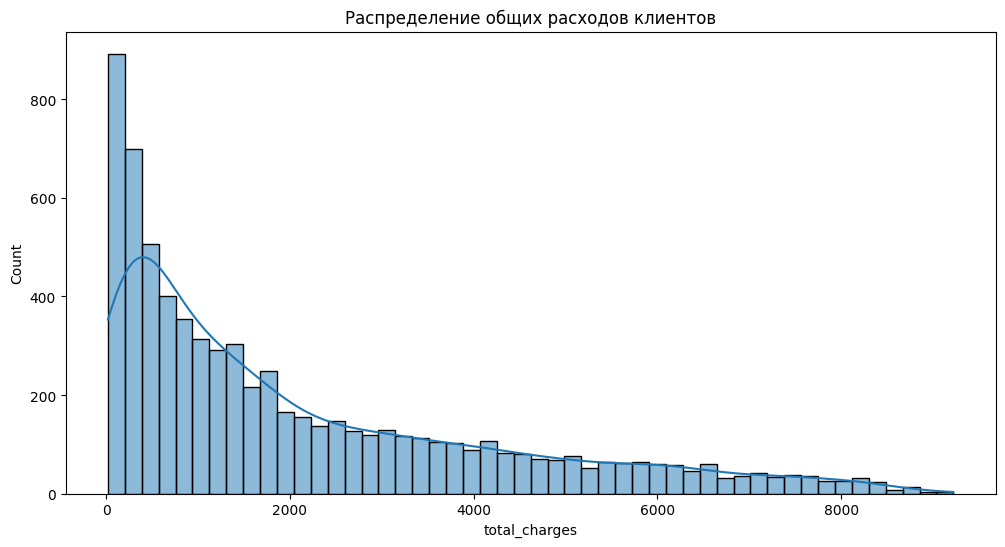

In [78]:
# Гистаграмма распределения общих расходов клиентов
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='total_charges', bins=50, kde=True)
plt.title('Распределение общих расходов клиентов')
plt.show()

Распределение общих расходов клиентов имеет экспоненциальный характер. Это означает, что небольшая часть клиентов тратит значительную сумму, в то время как большая часть пользователей расходует гораздо меньше.

In [79]:
# Проверка: расходы за месяц не превышают общие расходы
len(data.query('monthly_charges > total_charges'))

0

In [80]:
# Проверка: корреляция между отношение общих расходов/расходов за месяц и продолжительностью контракта
data['duration_of_contract'].corr(data['total_charges']/data['monthly_charges']).round(3)

0.999

## Общий вывод по исследованию данных

1. **Тип оплаты**
Среди клиентов, платящих ежемесячно, только 11% расторгли договор.  
Среди пользователей, оплачивающих раз в год и раз в два года, процент расторжений составляет 21% и 22% соответственно.

2. **Метод оплаты**  
Электронный чек является наиболее предпочтительным методом оплаты.  
Однако пользователи, использующие банковский перевод и кредитные карты, также демонстрируют высокий уровень отказов от услуг оператора.  
Объединение этих двух методов в одну группу позволит более точно анализировать отказ.

3. **Ежемесячные расходы**  
Клиенты, тратящие более 90 долларов, имеют наибольший процент отказов от услуг оператора, что может свидетельствовать о неудовлетворенности или проблемах с сервисом.

4. **Срок действия контракта**  
В среднем, пользователи, принявшие решение о расторжении договора, использовали услуги оператора от 1.5 до 3.5 лет.  
Медианное значение составляет 2.5 года.

5. **Дополнительные услуги**  
Наличие дополнительных услуг связано с более высоким уровнем расторжений, что указывает на несоответствие ожиданий пользователей и реального качества сервиса.  
Наибольшая разница в проценте расторжений наблюдается среди клиентов, использующих стриминговое телевидение, облачное хранилище и антивирусное ПО.  
Для пользователей, подключивших телефон к нескольким линиям одновременно, процент расторжений составляет 22.8%.

6. **Семейное положение**  
Клиенты, находящиеся в браке, в два раза чаще отказываются от услуг оператора.

7. **Неактуальные признаки**  
Признаки такие как электронный расчётный лист, пол и наличие детей не показались мне значимыми для окончательного датасета для машинного обучения.

Анализ показывает, что тип и метод оплаты, а также наличие дополнительных услуг и семейное положение клиентов влияют на уровень расторжений договоров. Неактуальные признаки следует исключить для повышения точности моделей машинного обучения. Окончательное решение приму после проверки на мультиколлинеарность.

# Предобработка данных

## Объединение таблиц

Объединение таблиц по ID клиента будет выполнено с исключением нескольких столбцов:

1. Столбцы с датами: begin_date и end_date, так как временные ряды не используются. Вместо этого создан новый признак с продолжительностью контракта.
2. total_charges - отсутствует необходимость в признаке общего расхода клиентов, так как совместно с  признаком monthly_charges он будет коррелировать с признаком продолжительности контракта.
3. Признак с полом клиента, так как не было найдено связи с целевым признаком.

Для объединения таблиц, содержащих информацию о договорах и персональных данных, используется метод merge с параметром inner. Это позволяет создать результирующий DataFrame, включающий только те строки, которые имеют совпадающие значения в столбце customer_id во всех таблицах. В случае таблиц, содержащих данные об услугах интернета и телефонии, я буду использовать полный метод объединения, так как могут быть клиенты, пользующиеся только одним видом услуги.

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   begin_date            7043 non-null   datetime64[ns]
 2   end_date              7043 non-null   datetime64[ns]
 3   type                  7043 non-null   object        
 4   paperless_billing     7043 non-null   object        
 5   payment_method        7043 non-null   object        
 6   monthly_charges       7043 non-null   float64       
 7   total_charges         7032 non-null   float64       
 8   gender                7043 non-null   object        
 9   senior_citizen        7043 non-null   object        
 10  partner               7043 non-null   object        
 11  dependents            7043 non-null   object        
 12  internet_service      7043 non-null   object        
 13  online_security   

In [82]:
data.drop(columns=['customer_id', 'begin_date', 'end_date', 'total_charges', 'gender'], inplace=True)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  7043 non-null   object 
 1   paperless_billing     7043 non-null   object 
 2   payment_method        7043 non-null   object 
 3   monthly_charges       7043 non-null   float64
 4   senior_citizen        7043 non-null   object 
 5   partner               7043 non-null   object 
 6   dependents            7043 non-null   object 
 7   internet_service      7043 non-null   object 
 8   online_security       7043 non-null   object 
 9   online_backup         7043 non-null   object 
 10  device_protection     7043 non-null   object 
 11  tech_support          7043 non-null   object 
 12  streaming_tv          7043 non-null   object 
 13  streaming_movies      7043 non-null   object 
 14  multiple_lines        7043 non-null   object 
 15  departed             

## Проверка на мультиколлинеарность

In [84]:
# Определите список числовых признаков
interval_cols = ['monthly_charges', 'duration_of_contract']

# Вычислите phik-матрицу с указанными числовыми признаками
phik_overview = data.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,departed,duration_of_contract
type,1.00,0.11,0.28,0.39,0.09,0.18,0.15,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.09,0.63
paperless_billing,0.11,1.00,0.37,0.47,0.24,0.01,0.17,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.08,0.03
payment_method,0.28,0.37,1.00,0.40,0.29,0.24,0.22,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.21,0.35
monthly_charges,0.39,0.47,0.40,1.00,0.30,0.20,0.18,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.23,0.39
senior_citizen,0.09,0.24,0.29,0.30,1.00,0.02,0.32,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.09,0.06
partner,0.18,0.01,0.24,0.20,0.02,1.00,0.65,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.23,0.45
dependents,0.15,0.17,0.22,0.18,0.32,0.65,1.00,0.11,0.12,0.10,0.09,0.11,0.09,0.08,0.01,0.05,0.20
internet_service,0.51,0.23,0.32,0.92,0.16,0.00,0.11,1.00,0.95,0.94,0.94,0.95,0.95,0.95,0.74,0.06,0.06
online_security,0.64,0.21,0.32,0.81,0.13,0.09,0.12,0.95,1.00,0.95,0.95,0.95,0.94,0.94,0.54,0.06,0.35
online_backup,0.58,0.20,0.29,0.82,0.11,0.09,0.10,0.94,0.95,1.00,0.95,0.95,0.95,0.95,0.56,0.09,0.37


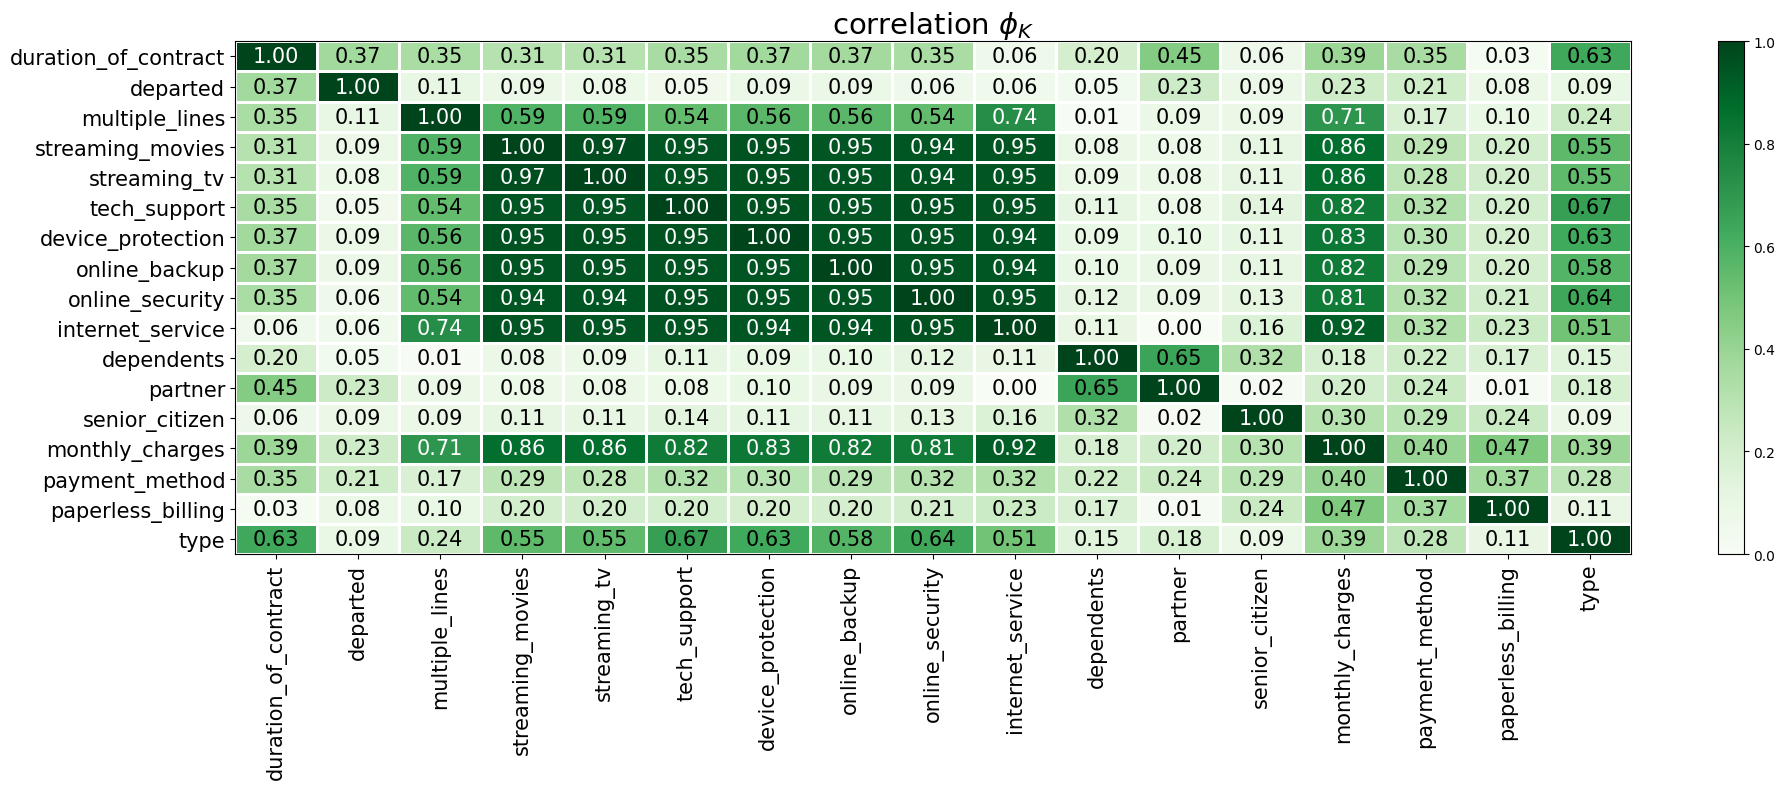

In [85]:
# Тепловая карта корреляции
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(20, 8))
plt.tight_layout()

Существует достаточно высокая корреляция между признаками:
 * type - duration_of_contract
 * type - online_security
 * type - tech_support

Также имеется значительная корреляция между суммой, которую клиент платит ежемесячно, и наличием определенных услуг. Это может указывать на то, что данные услуги значительно влияют на ежемесячные платежи.

Также интернет услуги сильно коррелируют между собой.

Глобальный коэффициент корреляции - это полезная мера, выражающая общую корреляцию одной переменной со всеми другими переменными в наборе данных. Это дает нам представление о том, насколько хорошо одна переменная может быть смоделирована с использованием других переменных.

/usr/local/lib/python3.10/dist-packages/phik/phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(


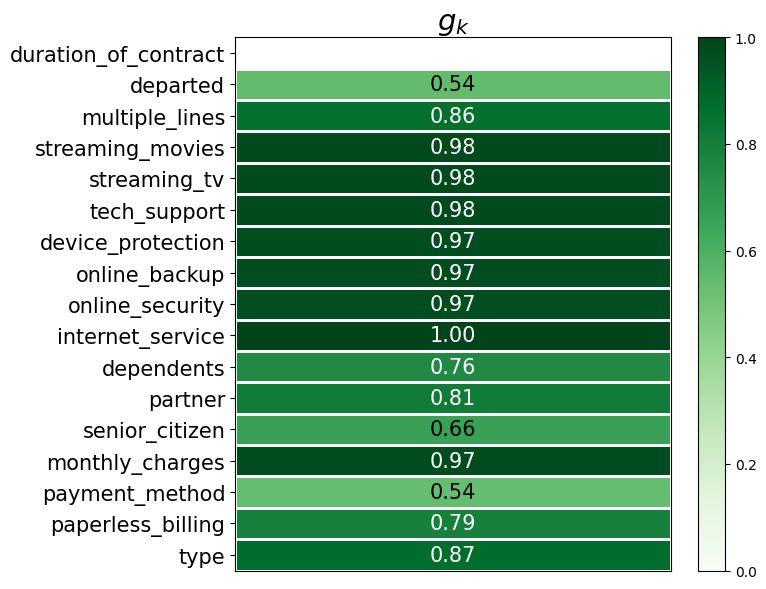

In [86]:
global_correlation, global_labels = data.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation,
                        x_labels=[''], y_labels=global_labels,
                        vmin=0, vmax=1, figsize=(8,6),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

При анализе тепловой карты глобальной корреляции видно, что признак internet_service может быть полностью смоделирован с помощью других признаков, поэтому его можно исключить из данных.

In [87]:
# исследование линейной связи между численными признаками
data[['monthly_charges', 'duration_of_contract']].corr()

,monthly_charges,duration_of_contract
monthly_charges,1.000000,0.220054
duration_of_contract,0.220054,1.000000


Оставлены интернет-услуги, такие как online_backup, streaming_movies, online_security, device_protection и streaming_movies, из-за их относительно высокой корреляции с целевым признаком. Применение регуляризации в моделях должно помочь снизить влияние мультиколлинеарности.

Решено исключить признаки: internet_service, tech_support, streaming_tv.

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  7043 non-null   object 
 1   paperless_billing     7043 non-null   object 
 2   payment_method        7043 non-null   object 
 3   monthly_charges       7043 non-null   float64
 4   senior_citizen        7043 non-null   object 
 5   partner               7043 non-null   object 
 6   dependents            7043 non-null   object 
 7   internet_service      7043 non-null   object 
 8   online_security       7043 non-null   object 
 9   online_backup         7043 non-null   object 
 10  device_protection     7043 non-null   object 
 11  tech_support          7043 non-null   object 
 12  streaming_tv          7043 non-null   object 
 13  streaming_movies      7043 non-null   object 
 14  multiple_lines        7043 non-null   object 
 15  departed             

In [89]:
data.drop(columns=['internet_service', 'tech_support', 'streaming_tv'], inplace=True)

## Подготовка обучающей и тестовой выборки

In [90]:
X = data.drop(columns={'departed'})
y = data['departed']

X.head()

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,streaming_movies,multiple_lines,duration_of_contract
0,One year,Yes,Mailed check,65.6,0,Yes,Yes,No,Yes,No,No,No,276
1,Month-to-month,No,Mailed check,59.9,0,No,No,No,No,No,Yes,Yes,276
2,Month-to-month,Yes,Electronic check,73.9,0,No,No,No,No,Yes,No,No,153
3,Month-to-month,Yes,Electronic check,98.0,1,Yes,No,No,Yes,Yes,Yes,No,427
4,Month-to-month,Yes,Mailed check,83.9,1,Yes,No,No,No,No,No,No,153


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5282, 13) (1761, 13) (5282,) (1761,)


In [92]:
y_train.value_counts()

,count
departed,
False,4456
True,826


In [93]:
X_train.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'streaming_movies',
       'multiple_lines', 'duration_of_contract'],
      dtype='object')

In [94]:
# проверка на наличие дубликатов (похожих клиентов)
print('Количество дубликатов:', X_train.duplicated().sum())
# Удаление дупликатов
X_train = X_train.drop_duplicates()
# Удаление строк с тем же индексом в y_train
y_train = y_train.loc[X_train.index]

Количество дубликатов: 24


In [95]:
columns_to_convert = ['type', 'paperless_billing', 'payment_method',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'streaming_movies',
       'multiple_lines']
X_train[columns_to_convert] = X_train[columns_to_convert].astype('category')

#Определение списка столбцов категориальных и числовых данных в обучающем наборе X_train.
cat_col = X_train.select_dtypes(include='category').columns.tolist()
num_col = X_train.select_dtypes(include='number').columns.tolist()

print('cat_columns:', cat_col,
      'num_columns:', num_col)

# Кодирование
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_col),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_col)
    ]
)

cat_columns: ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'streaming_movies', 'multiple_lines'] num_columns: ['monthly_charges', 'duration_of_contract']


<ipython-input-95-c80966dcf1e7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[columns_to_convert] = X_train[columns_to_convert].astype('category')


In [96]:
#проверка
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5258 entries, 5748 to 4442
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   type                  5258 non-null   category
 1   paperless_billing     5258 non-null   category
 2   payment_method        5258 non-null   category
 3   monthly_charges       5258 non-null   float64 
 4   senior_citizen        5258 non-null   category
 5   partner               5258 non-null   category
 6   dependents            5258 non-null   category
 7   online_security       5258 non-null   category
 8   online_backup         5258 non-null   category
 9   device_protection     5258 non-null   category
 10  streaming_movies      5258 non-null   category
 11  multiple_lines        5258 non-null   category
 12  duration_of_contract  5258 non-null   int64   
dtypes: category(11), float64(1), int64(1)
memory usage: 181.2 KB


In [97]:
#трансформация данных для НН
X_train_nn = column_transformer.fit_transform(X_train)
X_test_nn = column_transformer.transform(X_test)
print('нулевой элемент x_train:', X_train_nn[0])

нулевой элемент x_train: [ 0.52133183 -1.14732446  0.          0.          1.          0.
  1.          0.          0.          0.          0.          1.
  0.          1.          0.          1.          0.          0.
  1.          1.          0.        ]


In [98]:
# Преобразование в тензор
X_train_nn =  torch.FloatTensor(X_train_nn)
X_test_nn =  torch.FloatTensor(X_test_nn)
y_train_nn =  torch.FloatTensor(y_train.values)
y_test_nn =  torch.FloatTensor(y_test.values)

In [99]:
print('X_train_nn.shape:', X_train_nn.shape)
print('X_test_nn.shape:', X_test_nn.shape)
print('y_train_nn.shape:', y_train_nn.shape)
print('y_test_nn.shape:', y_test_nn.shape)

X_train_nn.shape: torch.Size([5258, 21])
X_test_nn.shape: torch.Size([1761, 21])
y_train_nn.shape: torch.Size([5258])
y_test_nn.shape: torch.Size([1761])


# Обучение моделей

Будут созданы четыре модели: RandomForestClassifier, CatBoostClassifier, LGBMClassifier и нейронная модель на PyTorch.

Расчет моделей  RandomForestClassifier, CatBoostClassifier и LGBMClassifierбудет происходить с балансировкой классов с помощью гиперпараметров.

В качестве метрики применяется roc_auc. Использование метрики roc_auc позволяет более точно оценить качество классификации, особенно при наличии несбалансированных классов. Это делает roc_auc особенно подходящей для задач, где важно учитывать как истинно положительные, так и истинно отрицательные предсказания.

### Создание pipeline с использованием  гиперпараметров для балансировки классов

In [100]:
# Создание конвейера
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

## Обучение моделей

### RandomForestClassifier

In [101]:
# Определение параметров для RandomForestClassifier
params = [
    {
        'model__n_estimators': [100, 125, 150, 200],
        'model__max_depth': [4, 5, 6],
        'model__min_samples_split': [3, 5, 7, 10]
    }
]


# Настройка GridSearchCV
grid = GridSearchCV(
    pipeline,
    params,
    cv=3,
    verbose=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'duration_of_contract']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=16924))]),
             n_jobs=-1,
             param_grid=[{'model__max_depth': [4, 5, 6],
                          'model__min_samples_split': [3, 5, 7, 10],
                          'model__n_estimators': [100, 125, 150, 200]}],
             scoring='roc_auc', verbose=5)

In [102]:
# Создание таблицы
table = pd.DataFrame(
    {
    'model':['rfc_balanced'],
    'params': [grid.best_params_],
    'score': [round(grid.best_score_, 4)]
})

In [103]:
table

,model,params,score
0,rfc_balanced,"{'model__max_depth': 6, 'model__min_samples_sp...",0.816


### Модели с бустинговым алгоритмом

In [104]:
# Определение параметров для моделей c pipeline_boost
params = [
    {
        'model': [LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__n_estimators': [300, 350, 400, 500],
        'model__learning_rate': [0.0001, 0.001, 0.01],
        'model__max_depth': [4, 5, 6, 7]
    },
    {
        'model': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'model__iterations': [350, 400, 500, 550],
        'model__learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'model__depth': [4, 5, 6, 7],
        'model__scale_pos_weight': [0.5, 1, 2, 3, 4]
    }
]


# Настройка GridSearchCV
grid = GridSearchCV(
    pipeline,
    params,
    cv=3,
    verbose=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

Fitting 3 folds for each of 368 candidates, totalling 1104 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'duration_of_contract']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'online_security'...
                          'model__learning_rate': [0.0001, 0.001, 0.01],
                          'model__max_depth': [4, 5, 6, 7],
                          'model__n_estimators': [300, 350, 400, 500]},
                         {'model': [<catboost.core.CatBoostClassifier object at 0x7809647941f0>],
                          'model__depth': [4, 5, 6, 7],
                          'model__iterations': [350, 400, 500, 550],
                          'model__learning_rate': [0.0001, 0.001, 0.01, 0.1],
                          'model__scale_pos_weight': [0.5, 1, 2, 3, 4]}],
             scoring='roc_auc', verbose=5)

In [105]:
# Собираем данные для модели
new_result = {
    'model': ['model_boost_balanced'],
    'params': [grid.best_params_],
    'score': [grid.best_score_]
}
# Объединяем с таблицей
table = pd.concat([table, pd.DataFrame(new_result, index=[1])])
table

,model,params,score
0,rfc_balanced,"{'model__max_depth': 6, 'model__min_samples_sp...",0.816000
1,model_boost_balanced,{'model': <catboost.core.CatBoostClassifier ob...,0.906678


## Нейронная сеть

In [106]:
class DenseModel(nn.Module):
    def __init__(self, input_dim):
        super(DenseModel, self).__init__()
        self.linear1 = nn.Linear(in_features=input_dim, out_features=256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.linear2 = nn.Linear(in_features=256, out_features=128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.linear3 = nn.Linear(in_features=128, out_features=32)
        self.batchnorm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()

        self.linear4 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batchnorm1(self.linear1(x))))
        x = self.dropout2(self.relu2(self.batchnorm2(self.linear2(x))))
        x = self.relu3(self.batchnorm3(self.linear3(x)))
        x = self.sigmoid(self.linear4(x))
        return x

In [107]:
# Параметры кросс-валидации
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = []

# Кросс-валидация
for train_index, val_index in kf.split(X_train_nn):
    X_train_fold, X_val_fold = X_train_nn[train_index], X_train_nn[val_index]
    y_train_fold, y_val_fold = y_train_nn[train_index], y_train_nn[val_index]

    model = DenseModel(input_dim=X_train_fold.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()

    # Обучение модели
    model.train()
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = model(X_train_fold)
        loss = criterion(outputs.view(-1), y_train_fold)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:  # Вывод результатов каждые 100 эпох
            print(f'Epoch [{epoch}/5000], Loss: {loss.item():.4f}')

    # Оценка модели на валидационной выборке
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_fold)
        val_outputs = val_outputs.numpy()
        metric = roc_auc_score(y_val_fold.numpy(), val_outputs)
        roc_auc_scores.append(metric)

# Средний ROC AUC
average_roc_auc = round(np.mean(roc_auc_scores), 2)
print(f'Average Validation ROC AUC: {average_roc_auc}')

Epoch [0/5000], Loss: 0.6341
Epoch [100/5000], Loss: 0.5522
Epoch [200/5000], Loss: 0.5013
Epoch [300/5000], Loss: 0.4676
Epoch [400/5000], Loss: 0.4330
Epoch [500/5000], Loss: 0.4102
Epoch [600/5000], Loss: 0.3911
Epoch [700/5000], Loss: 0.3742
Epoch [800/5000], Loss: 0.3635
Epoch [900/5000], Loss: 0.3500
Epoch [1000/5000], Loss: 0.3449
Epoch [1100/5000], Loss: 0.3343
Epoch [1200/5000], Loss: 0.3304
Epoch [1300/5000], Loss: 0.3135
Epoch [1400/5000], Loss: 0.3194
Epoch [1500/5000], Loss: 0.3185
Epoch [1600/5000], Loss: 0.3076
Epoch [1700/5000], Loss: 0.3075
Epoch [1800/5000], Loss: 0.3004
Epoch [1900/5000], Loss: 0.2993
Epoch [2000/5000], Loss: 0.3014
Epoch [2100/5000], Loss: 0.2969
Epoch [2200/5000], Loss: 0.2922
Epoch [2300/5000], Loss: 0.3000
Epoch [2400/5000], Loss: 0.2898
Epoch [2500/5000], Loss: 0.2865
Epoch [2600/5000], Loss: 0.2843
Epoch [2700/5000], Loss: 0.2858
Epoch [2800/5000], Loss: 0.2798
Epoch [2900/5000], Loss: 0.2840
Epoch [3000/5000], Loss: 0.2793
Epoch [3100/5000], L

In [108]:
new_result = {
    'model':['nn'],
    'params': 0,
    'score': [average_roc_auc]
}

table = pd.concat([table, pd.DataFrame(new_result, index=[2])])

## Выбор лучшей модели

In [109]:
table

,model,params,score
0,rfc_balanced,"{'model__max_depth': 6, 'model__min_samples_sp...",0.816000
1,model_boost_balanced,{'model': <catboost.core.CatBoostClassifier ob...,0.906678
2,nn,0,0.780000


In [110]:
#сортирую таблицу по приоритетам:
display(table.sort_values(by=['score'],ascending=[False]).iloc[0])

,1
model,model_boost_balanced
params,{'model': <catboost.core.CatBoostClassifier ob...
score,0.906678


In [111]:
table['params'][1]

{'model': <catboost.core.CatBoostClassifier at 0x7809647941f0>,
 'model__depth': 4,
 'model__iterations': 550,
 'model__learning_rate': 0.1,
 'model__scale_pos_weight': 1}

**Лучашя модель CatBoostClassifier с параметрами:**
- random_state=16924,
- verbose=0,
- depth = 4,
- iterations = 550,
- learning_rate = 0.1,
- scale_pos_weight = 1

# Тестирование модели

In [117]:
#Обучение лучшей модели:
best_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=0,
    depth = 4,
    iterations = 550,
    learning_rate = 0.1,
    scale_pos_weight = 1
    )
pipeline = Pipeline([('preprocessor', column_transformer),
                    ('model', best_model)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'duration_of_contract']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'streaming_movies',
                                                   'multiple_lines'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7809642fce80>)])

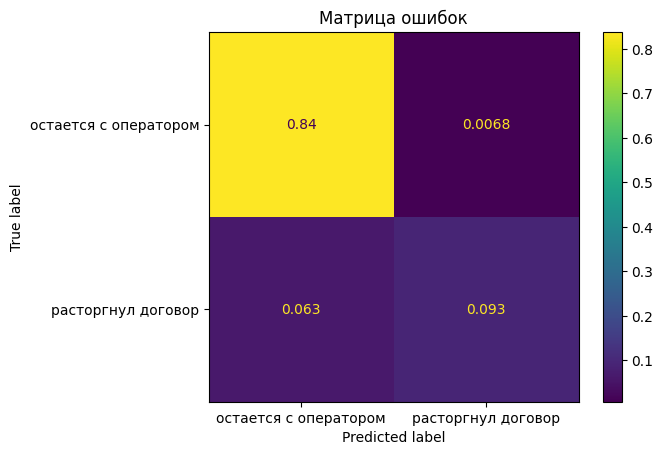

In [118]:
# Предсказание с использованием pipeline
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='all')

# Отображение матрицы ошибок
cmd = ConfusionMatrixDisplay(cm, display_labels=['остается с оператором', 'расторгнул договор'])
cmd.plot()
plt.title('Матрица ошибок')
plt.show()


На основе предоставленных данных можно сделать вывод, что модель демонстрирует высокую точность в классификации истинно отрицательных ответов (0.84), однако имеет низкую точность в классификации истинно положительных ответов (0.093). Ложноположительные предсказания (0.063) меньше, чем ложноотрицательные (0.068), что указывает на то, что модель чаще ошибается, пропуская истинные положительные случаи.

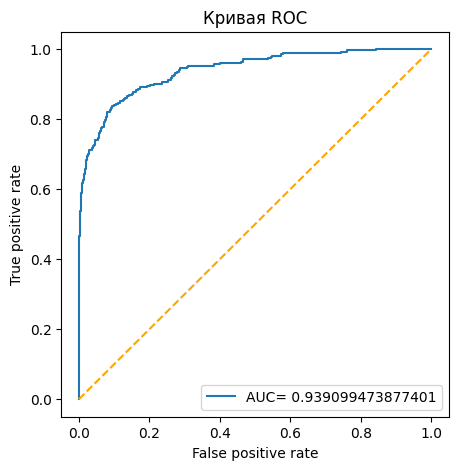

In [119]:
plt.figure(figsize=(5, 5))
probabilities = pipeline.predict_proba(X_test)
probabilities_test = probabilities[:,1]
roc_auc = roc_auc_score(y_test, probabilities_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test)
plt.plot(fpr, tpr, label='AUC= '+ str(roc_auc))
plt.plot([0, 1], '--', color='orange')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend(loc=4)
plt.title('Кривая ROC');

Точность: 0.93
Полнота: 0.60
Accuracy: 0.93


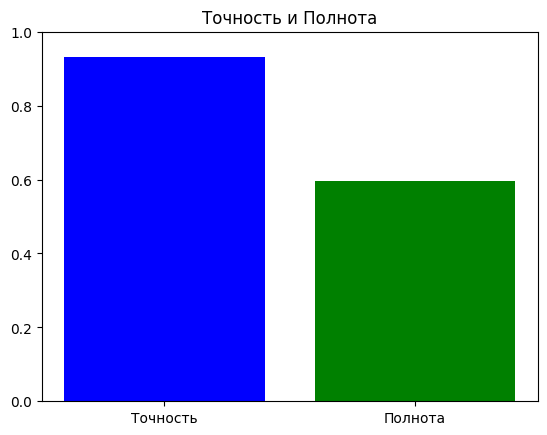

In [120]:
# Расчет точности и полноты
y_pred = pipeline.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Точность: {precision:.2f}")
print(f"Полнота: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Визуализация точности и полноты
plt.bar(['Точность', 'Полнота'], [precision, recall], color=['blue', 'green'])
plt.title('Точность и Полнота')
plt.ylim(0, 1)
plt.show()

Точность составляет 0.93, что означает, что когда модель предсказывает положительный класс, она правильно делает это примерно в 93% случаев. Полнота равна 0.60, что указывает на то, что модель успешно идентифицирует примерно 60% всех реальных положительных случаев в данных. Accuracy: 0.93.

## Анализ важности признаков

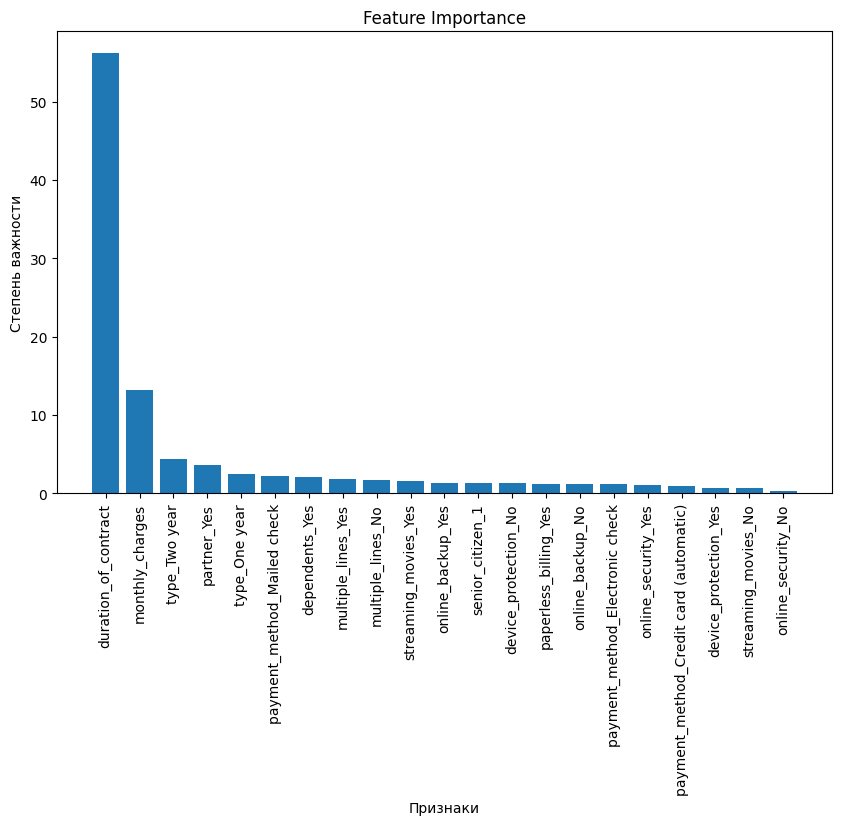

In [116]:
feature_names = []
feature_importances = pipeline.named_steps['model'].feature_importances_

for transformer in column_transformer.transformers_:
    transformer_name, transformer, columns = transformer
    if isinstance(transformer, OneHotEncoder):
        for col, cats in zip(columns, transformer.categories_):
            feature_names.extend([f"{col}_{cat}" for cat in cats[1:]])
    else:
        feature_names.extend(columns)

# Sorting feature importance
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.xlabel('Признаки')
plt.ylabel('Степень важности')
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.show()

Модель посчитала важными такие признаки как:
- продолжительность договора
- ежемесячная оплата
- тип оплаты: раз в два года
- наличие у клиента супруг(а)
- тип оплаты: раз в год


# Общий вывод

1. **Исследование данных**

Тип и метод оплаты, а также наличие дополнительных услуг и семейное положение клиентов влияют на уровень расторжений договоров. Клиенты, платящие ежемесячно, имеют меньший процент расторжений (11%) по сравнению с теми, кто оплачивает раз в год (21%) или раз в два года (22%). Предпочтительный метод оплаты – электронный чек. Высокий процент расторжений наблюдается у клиентов с ежемесячными расходами более 90 долларов и у состоящих в браке. Наличие дополнительных услуг также связано с повышением отказов.

2. **Подготовка данных**

Решено исключить признаки: internet_service, online_security, tech_support из-за их низкой корреляции с целевым признаком.

3. **Обучение модели**

Созданы четыре модели: RandomForestClassifier, CatBoostClassifier, LGBMClassifier и нейронная модель на PyTorch.

Расчет моделей  RandomForestClassifier, CatBoostClassifier и LGBMClassifier происходит с балансировкой классов с помощью гиперпараметров.

В качестве метрики применяется roc_auc.

4. **Лучшая модель**

**Лучашя модель CatBoostClassifier с параметрами:**
- random_state=16924,
- verbose=0,
- depth = 4,
- iterations = 550,
- learning_rate = 0.1,
- scale_pos_weight = 1

5. Анализ результатов тестирования модели

На основе предоставленных данных можно сделать вывод, что модель демонстрирует высокую точность в классификации истинно отрицательных ответов (0.84), однако имеет низкую точность в классификации истинно положительных ответов (0.093). Ложноположительные предсказания (0.063) меньше, чем ложноотрицательные (0.068), что указывает на то, что модель чаще ошибается, пропуская истинные положительные случаи.

- Кривая ROC расположена выше кривой случайных ответов. Значение AUC = 0.94.

- Точность и полнота:

Точность составляет 0.93, что означает, что когда модель предсказывает положительный класс, она правильно делает это примерно в 93% случаев. Полнота равна 0.60, что указывает на то, что модель успешно идентифицирует примерно 60% всех реальных положительных случаев в данных. Accuracy: 0.93.
  
**6.Анализ важности признаков**

Модель посчитала важными такие признаки как:
- продолжительность договора
- ежемесячная оплата
- тип оплаты: раз в два года
- наличие у клиента супруг(а)
- тип оплаты: раз в год
